# Load Dataset, Transformer, dan Library-Library yang digunakan

In [1]:
!pip install torch torchvision transformers datasets

In [2]:
from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load the dataset
dataset = ImageFolder(root='./Dataset', transform=transform)


# Split into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [19]:
print(dataset.class_to_idx)

{'Bus': 0, 'Car': 1, 'Truck': 2, 'motorcycle': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


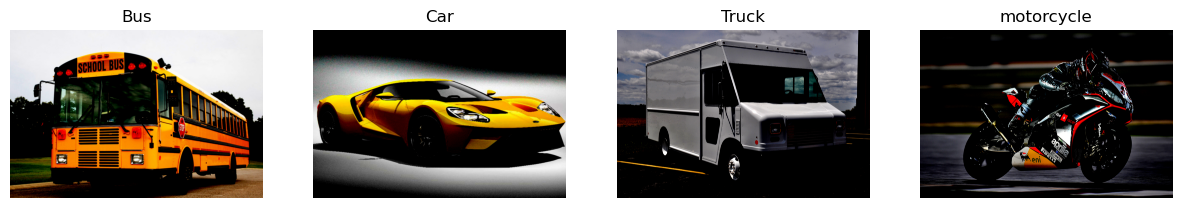

In [26]:
import matplotlib.pyplot as plt

plot_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

plot_dataset = ImageFolder(root='./Dataset', transform=plot_transform)

# Get class names from the dataset
class_names = plot_dataset.classes  # Extract class names from the dataset
class_to_idx = plot_dataset.class_to_idx  # Mapping of class names to indices

# Initialize a dictionary to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(15, 10))

# Loop through the dataset to find the first image of each class
for i, (image, label) in enumerate(plot_dataset):  # dataset returns (image, label)
    if label not in shown_labels:
        plt.subplot(1, len(class_names), len(shown_labels) + 1)
        plt.imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to numpy for plotting
        plt.title(class_names[label])
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(class_names):
            break

plt.show()

In [12]:
from transformers import ViTForImageClassification, ViTImageProcessor

model_name = "google/vit-base-patch16-224-in21k"

# Load the pre-trained ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(dataset.classes)  # Total number of classes
)

# Optional: Update the processor for resizing images
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

model.safetensors:   3%|3         | 10.5M/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [13]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Fine Tuning

In [14]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = CrossEntropyLoss()

In [16]:
from tqdm import tqdm

epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}")

 90%|█████████ | 9/10 [00:25<00:02,  2.47s/it]

In [17]:
model.save_pretrained("./fine_tuned_vit")

In [25]:
from PIL import Image
import torch

model = ViTForImageClassification.from_pretrained("./fine_tuned_vit")
model.eval()

def predict(image_path):
    from PIL import Image

    # Open and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)  # Move inputs to the correct device

    # Perform inference
    model.eval()  # Ensure the model is in evaluation mode
    model.to(device)  # Move model to the correct device
    with torch.no_grad():
        outputs = model(**inputs).logits  # Ensure both inputs and model are on the same device
        predicted_class = outputs.argmax(-1).item()
        class_name = dataset.classes[predicted_class]

    return class_name


print(predict("image_1.jpg"))

motorcycle


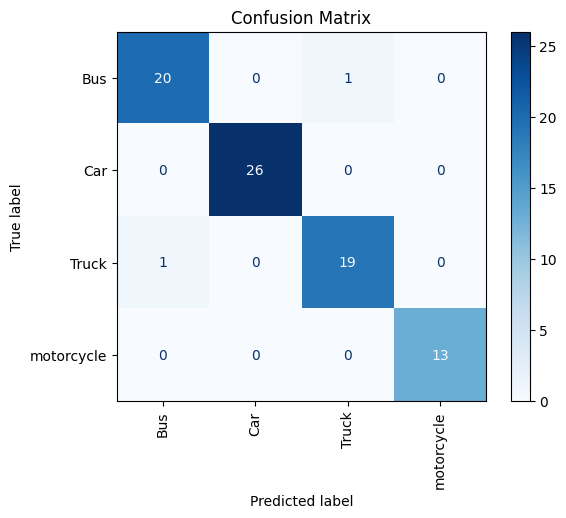

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Function to compute predictions for the entire validation dataset
def compute_confusion_matrix(model, val_loader, classes, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Ensure the model is on the correct device

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(classes)))
    return cm

# Compute the confusion matrix
cm = compute_confusion_matrix(model, val_loader, dataset.classes, device)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()